In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

train_set = torchvision.datasets.FashionMNIST(root = ".", train=True, download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root = ".", train=False,download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [2]:
# Fix the seed to be able to get the same randomness across runs and
# hence reproducible outcomes
torch.manual_seed(0)
# If you are using CuDNN, otherwise you can just ignore
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

In [3]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [4]:
example_data.shape

torch.Size([32, 1, 28, 28])

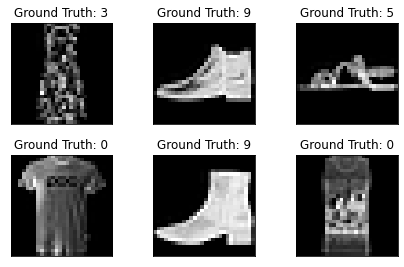

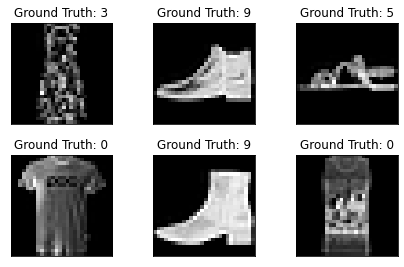

In [5]:
# visualize examples from the dataset
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
n_epochs = 30
batch_size_train = 32
batch_size_test = 1000
learning_rate = 0.1
#learning_rate = [0.001, 0.1, 0.5, 1, 10]  used this for part c) when list of learning rates is required to check training and test accuracy values
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [8]:
class Net(nn.Module): 
    def __init__(self):

        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        torch.nn.init.xavier_uniform(self.conv1.weight)
        #self.conv2_drop = nn.Dropout2d()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 10)

    def init_weights(self, m):
        """Define the weights"""
        return nn.init.xavier_uniform(m.weight)  # xavier initialization of weights

    def forward(self, x):
        """Define the forward function"""
        #m = nn.Sigmoid()  sigmoid activation function
        #m = nn.Tanh()  tanh activation function
        #x = F.elu(F.max_pool2d(self.conv1(x), 2)) elu activation function
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # relu activation function - default activation function
        #x = F.dropout(x, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
network = Net() # define the object of class Net

# initialize the optimizer, learning rate and momentum
optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

<ipython-input-8-275634db3ee1>:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.conv1.weight)


In [10]:
network

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [11]:
# initialize the training, test losses and train, test counter
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [12]:
def train(epoch):
  """"Model train function"""
  network.train()

  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    #train_losses.append(loss.item()) uncomment this to get sum of losses per epoch
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

  # training accuracy at the end of each epoch
  correct = 0
  for data, target in train_loader: 
      output = network(data)  
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  return (100. * correct / len(train_loader.dataset))

In [13]:
def test():
  """Model test function"""
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  return (100. * correct / len(test_loader.dataset))

In [14]:
#n_epochs=30
train_accuracy = []
test_accuracy = []
sum_train_losses = []

In [15]:
test_accuracy.append(test())
for epoch in range(1, n_epochs + 1):
  train_accuracy.append(train(epoch))
  test_accuracy.append(test())
  #sum_train_losses.append(sum(train_losses)/batch_size_train)
  #train_losses = []

<ipython-input-8-275634db3ee1>:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Streaming output truncated to the last 5000 lines.
Train Epoch: 4 [50240/60000 (84%)]	Loss: 0.404282
Train Epoch: 4 [50560/60000 (84%)]	Loss: 0.359769
Train Epoch: 4 [50880/60000 (85%)]	Loss: 0.243031
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.408461
Train Epoch: 4 [51520/60000 (86%)]	Loss: 0.063990
Train Epoch: 4 [51840/60000 (86%)]	Loss: 0.443220
Train Epoch: 4 [52160/60000 (87%)]	Loss: 0.108512
Train Epoch: 4 [52480/60000 (87%)]	Loss: 0.178063
Train Epoch: 4 [52800/60000 (88%)]	Loss: 0.126760
Train Epoch: 4 [53120/60000 (89%)]	Loss: 0.207226
Train Epoch: 4 [53440/60000 (89%)]	Loss: 0.088329
Train Epoch: 4 [53760/60000 (90%)]	Loss: 0.317197
Train Epoch: 4 [54080/60000 (90%)]	Loss: 0.162124
Train Epoch: 4 [54400/60000 (91%)]	Loss: 0.216652
Train Epoch: 4 [54720/60000 (91%)]	Loss: 0.121657
Train Epoch: 4 [55040/60000 (92%)]	Loss: 0.111354
Train Epoch: 4 [55360/60000 (92%)]	Loss: 0.120967
Train Epoch: 4 [55680/60000 (93%)]	Loss: 0.247078
Train Epoch: 4 [56000/60000 (93%)]	Loss: 0.253283

In [18]:
len(test_accuracy)

31

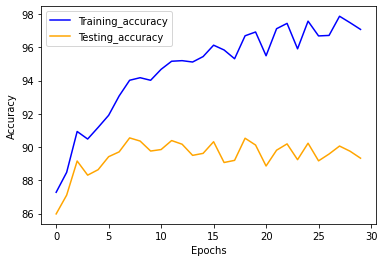

In [20]:
fig,ax = plt.subplots(1)
# plot the data

# initializing L with total number of epochs
L = list(range(0, n_epochs, 1))

# initialize the training and test accuracy
ax.plot(L, train_accuracy, color='blue', label="Training_accuracy")
ax.plot(L, test_accuracy, color='orange', label="Testing_accuracy")

# Set common labels
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend(loc='best')

In [24]:
import pandas as pd
# saving training and test accuracy
df = pd.DataFrame({'Epochs': L, 'Training_accuracy': train_accuracy, 'Test_accuracy': test_accuracy})
df

,Epochs,Training_accuracy,Test_accuracy
0,0,tensor(87.2800),tensor(85.9800)
1,1,tensor(88.4800),tensor(87.1100)
2,2,tensor(90.9350),tensor(89.1600)
3,3,tensor(90.4817),tensor(88.3100)
4,4,tensor(91.1817),tensor(88.6400)
5,5,tensor(91.9083),tensor(89.4200)
6,6,tensor(93.0717),tensor(89.7100)
7,7,tensor(94.0150),tensor(90.5500)
8,8,tensor(94.1683),tensor(90.3600)
9,9,tensor(94.0133),tensor(89.7600)


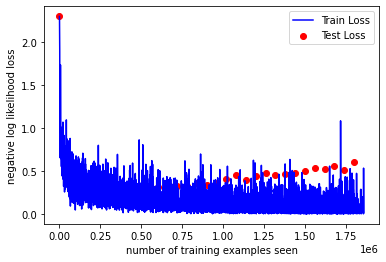

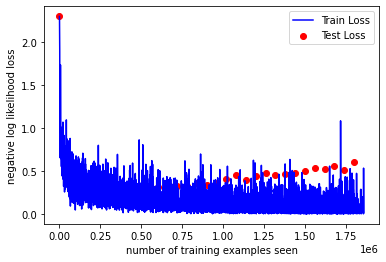

In [25]:
# plotting training and test loss
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [26]:
with torch.no_grad():
  output = network(example_data)


<ipython-input-8-275634db3ee1>:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [30]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

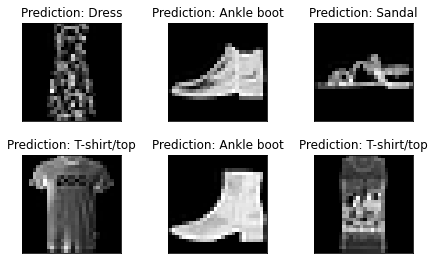

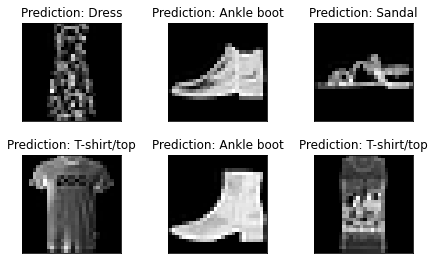

In [35]:
prediction_output = ""
fig = plt.figure()
for i in range(6):

  prediction_output= labels[output.data.max(1, keepdim=True)[1][i].item()]      
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(prediction_output))
  plt.xticks([])
  plt.yticks([])
fig